In [74]:
# Import necessary libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import simpy as sp
import copy

In [75]:
# Create simulation object now for reference, construct later
sim = None

In [79]:
# Define objects
class Node(object):
  # Properties
  label: int
  send_rate: float 
  mutate_rate: float 
  packets: set = None
  recieved: set = None

  # Metrics
  info_amount: int = 0
  cumulative_inacc: float = 0.0
  cumulative_rec: float = 0.0

  def __init__(self, env, label):
    # Create Node object
    self.label = label
    self.send_rate = np.abs(np.random.normal(scale=0.1))
    self.mutate_rate = np.random.rand(1)[0]
    self.mutate_dist = lambda : np.abs(np.random.normal(scale=0.1))
    self.packets = list()
    self.recieved = set()
    self.env = env

    # Run Node object
    self.env.process(self.run(self.env))

  def run(self, env):
    
    while True:
      # Wait
      wait_time = np.random.exponential(1.0/self.send_rate)
      yield env.timeout(wait_time)

      # If no packets to send, continue
      if len(self.packets) == 0:
        # print("Node {} no packets to send".format(self.label))
        continue
      # Pick packet 
      packet = np.random.choice(self.packets)
      # print("Node {} sending packet {}".format(self.label, packet.label))
      self.packets.remove(packet)
      # Mutate packet
      if np.random.rand(1)[0] > self.mutate_rate:
        mutate_val = self.mutate_dist()
        # print("Node {} mutated packet {} by {}".format(self.label, packet.label, mutate_val))
        packet.inacc = max([0, packet.inacc + mutate_val])
      # Send packet
      # Can either pick a neighbor or send to all neighbors
      # We are currently sending to all neighbors
      for n in sim.G.neighbors(self.label):
        # If neighbor is a source, don't send
        if n not in sim.nodes:
          continue
        node = sim.nodes[n]
        assert(isinstance(node, Node))
        # Copy packet 
        copy_packet = copy.copy(packet)
        # If neighbor already recieved packet, don't send
        if copy_packet.label in node.recieved:
          continue
        # Add packet to neighbors mailbox and update cumulatives
        node.packets.append(copy_packet)
        node.recieved.add(copy_packet.label)
        node.info_amount += 1
        node.cumulative_inacc += copy_packet.inacc
        print("Now:", env.now)
        print("Creation:", copy_packet.time_stamp)
        node.cumulative_rec += (env.now - copy_packet.time_stamp)

  def __str__(self):
    return "Node<label: {}, amount: {}, recency: {}>".format(self.label, self.info_amount, self.cumulative_rec)
    return "Node <label: {}, send_rate: {}, mutate_rate: {}>".format(self.label, self.send_rate, self.mutate_rate)

  def __repr__(self):
    return "Node<label: {}, amount: {}, recency: {}>".format(self.label, self.info_amount, self.cimulative_rec)

  def get_info_amount(self):
    return self.info_amount
    
  def get_info_inacc(self):
    return self.cumulative_inacc / float(self.info_amount) if self.info_amount != 0 else 0.0
    
  def get_info_recency(self):
    return self.cumulative_rec / float(self.info_amount) if self.info_amount != 0 else 0.0

class Source(object):
  # Properties
  label: int
  gen_rate: float

  def __init__(self, env, label):
    # Create Source object
    self.label = label
    self.gen_rate = np.random.rand(1)[0] / 10
    
    # Run Source object
    env.process(self.run(env))

  def run(self, env):
    while True:
      # Wait
      wait_time = np.random.exponential(1.0/self.gen_rate)
      yield env.timeout(wait_time)
      # Create packet
      packet = Packet(env)
      # print("Source {} creating packet {}".format(self.label, packet.label))
      # Send packet
      # Can either pick a neighbor or send to all neighbors
      # We are currently sending to all neighbors
      for n in sim.G.neighbors(self.label):
        # print("Source {} sending to {}".format(self.label, n))
        # If neighbor is a source, don't send
        if n not in sim.nodes:
          continue
        node = sim.nodes[n]
        assert(isinstance(node, Node))
        # Copy packet 
        copy_packet = copy.copy(packet)
        # If neighbor already recieved packet, don't send
        if copy_packet.label in node.recieved:
          continue
        # Add packet to neighbors mailbox and update cumulatives
        node.packets.append(copy_packet)
        node.recieved.add(copy_packet.label)
        node.info_amount += 1
        node.cumulative_inacc += copy_packet.inacc
        node.cumulative_recency = (env.now - copy_packet.time_stamp)


  def __str__(self):
    return "Source <label: {}, gen_rate: {}>".format(self.label, self.gen_rate)

  def __repr__(self):
    return "Source<label: {}>".format(self.label)

class Packet(object):
  num_packets: int = 0
  label: int 
  inacc: float = 0.0
  time_stamp: int
  
  def __init__(self, env):
    self.label = Packet.num_packets
    Packet.num_packets += 1
    self.time_stamp = env.now

  def __str__(self):
    return "Packet <label: {}, inacc: {}, time_stamp: {}>".format(self.label, self.inacc, self.time_stamp)

  def __repr__(self):
    return "Packet<label: {}>".format(self.label)

In [80]:
# Define simulation, construct network, and network initiation
class Simulation(object):
  """
    Holds network information.
  """

  G: nx.Graph

  def __init__(self, nsources=3, nnodes=250, pedge=0.04):
    self.env = sp.Environment()
    # Create network - scale-free network
    counter = 0
    G_tmp = nx.scale_free_graph(nsources + nnodes).to_undirected()
    # Convert scale free network into a simple graph
    self.G = nx.Graph()
    self.G.add_nodes_from(G_tmp)
    for u, v in G_tmp.edges():
      if not self.G.has_edge(u, v):
        self.G.add_edge(u, v)
    # self.G = nx.gnp_random_graph(nsources + nnodes, pedge)

    self.sources = dict()
    self.nodes = dict()
    for _ in range(nsources):
      self.sources[counter] = Source(self.env, counter)
      counter += 1
    for _ in range(nnodes):
      self.nodes[counter] = Node(self.env, counter)
      counter += 1

  def run(self, until):
    self.env.run(until=until)

  def graph(self, metric='amount'):

    # info_inaccs = [n.get_info_inacc() for n in self.nodes.values()]
    # info_recencies = [n.get_info_recency() for n in self.nodes.values()]

    # Position nodes
    pos = nx.kamada_kawai_layout(self.G)

    # Draw packet density graph
    # Calculate amounts, set size based on amounts
    info = None
    title = None
    if metric=='amount':
        info = np.array([n.get_info_amount() for n in self.nodes.values()]).astype(float)
        title = 'Packet density'
    elif metric=='inacc':
        info = np.array([n.get_info_inacc() for n in self.nodes.values()]).astype(float)    
        title = 'Packet inaccuracy'        
    elif metric=='recency':
        info = np.array([n.get_info_recency() for n in self.nodes.values()]).astype(float)
        for n in self.nodes.values():
            print(n)
        title = 'Packet recency'
        print(info)
    else:
        print("No metric of the name.")
        return
    
    info = info - min(info) 
    if max(info) != 0:
      info /= max(info)
    info = np.exp(5 * info + 1)
    np.linalg.norm(info)
  
    fig = plt.figure(1, figsize=(25, 25))
    fig.suptitle(title, fontsize=30)
    plt.axis('off')
    nx.draw_networkx_nodes(self.G, pos,
                           nodelist=list(self.sources.keys()),
                           node_color='black',
                           node_shape='s',
                           node_size=50)
    nx.draw_networkx_nodes(self.G, pos,
                           nodelist=list(self.nodes.keys()),
                           node_size=info,
                           node_color=info,
                           cmap='Reds')
    nx.draw_networkx_edges(self.G, pos,
                           edge_color='gray',
                           alpha=0.4)
    plt.show()
    # nx.draw(self.G, pos=pos, node_size=0, alpha=0.4, edge_color='r', font_size=12, with_labels=True)

    # plt.subplot(312)
    # plt.title('Packet accuracy')
    # nx.draw(self.G, pos=pos, node_size=0, alpha=0.4, edge_color='r', font_size=12, with_labels=True)

    # plt.subplot(313)
    # plt.title('Packet recency')
    # nx.draw(self.G, pos=pos, node_size=0, alpha=0.4, edge_color='r', font_size=12, with_labels=True)

In [81]:
sim = Simulation()
sim.run(150)

Now: 7.635924658478663
Creation: 4.2604247617332245
Now: 7.635924658478663
Creation: 4.2604247617332245
Now: 7.635924658478663
Creation: 4.2604247617332245
Now: 8.959772762497579
Creation: 4.2604247617332245
Now: 11.060848879022547
Creation: 10.192504394862686
Now: 11.060848879022547
Creation: 10.192504394862686
Now: 11.060848879022547
Creation: 10.192504394862686
Now: 11.060848879022547
Creation: 10.192504394862686
Now: 11.381341604234015
Creation: 9.314797913641232
Now: 11.381341604234015
Creation: 9.314797913641232
Now: 11.381341604234015
Creation: 9.314797913641232
Now: 11.381341604234015
Creation: 9.314797913641232
Now: 11.381341604234015
Creation: 9.314797913641232
Now: 11.381341604234015
Creation: 9.314797913641232
Now: 11.381341604234015
Creation: 9.314797913641232
Now: 11.381341604234015
Creation: 9.314797913641232
Now: 11.381341604234015
Creation: 9.314797913641232
Now: 11.381341604234015
Creation: 9.314797913641232
Now: 11.381341604234015
Creation: 9.314797913641232
Now: 11.

Now: 77.79358405619979
Creation: 68.01315196362131
Now: 78.07853215596025
Creation: 30.696102504153266
Now: 78.98276201731488
Creation: 35.20003062844839
Now: 79.35778775168693
Creation: 68.01315196362131
Now: 79.48132182171139
Creation: 71.83303585309145
Now: 79.48132182171139
Creation: 71.83303585309145
Now: 79.65713926826488
Creation: 9.314797913641232
Now: 79.65713926826488
Creation: 9.314797913641232
Now: 80.01089477991073
Creation: 9.314797913641232
Now: 80.01089477991073
Creation: 9.314797913641232
Now: 80.03732000966272
Creation: 71.83303585309145
Now: 80.03732000966272
Creation: 71.83303585309145
Now: 80.29213002447973
Creation: 4.529159529751247
Now: 81.43370007936682
Creation: 9.314797913641232
Now: 81.57232466671017
Creation: 4.2604247617332245
Now: 81.57232466671017
Creation: 4.2604247617332245
Now: 81.57232466671017
Creation: 4.2604247617332245
Now: 81.57232466671017
Creation: 4.2604247617332245
Now: 81.57232466671017
Creation: 4.2604247617332245
Now: 81.57232466671017
Cr

Now: 136.50444696768855
Creation: 55.415636813142
Now: 136.50444696768855
Creation: 55.415636813142
Now: 136.50444696768855
Creation: 55.415636813142
Now: 136.50444696768855
Creation: 55.415636813142
Now: 136.50444696768855
Creation: 55.415636813142
Now: 136.95836236602887
Creation: 105.75542084550412
Now: 137.28594216622616
Creation: 110.30177625779105
Now: 137.28594216622616
Creation: 110.30177625779105
Now: 137.28594216622616
Creation: 110.30177625779105
Now: 137.28594216622616
Creation: 110.30177625779105
Now: 137.9923995972665
Creation: 35.20003062844839
Now: 138.3242033823077
Creation: 4.2604247617332245
Now: 138.7357703305435
Creation: 30.696102504153266
Now: 139.04655957147162
Creation: 110.30177625779105
Now: 139.04655957147162
Creation: 110.30177625779105
Now: 139.04655957147162
Creation: 110.30177625779105
Now: 139.04655957147162
Creation: 110.30177625779105
Now: 139.04655957147162
Creation: 110.30177625779105
Now: 139.04655957147162
Creation: 110.30177625779105
Now: 139.054

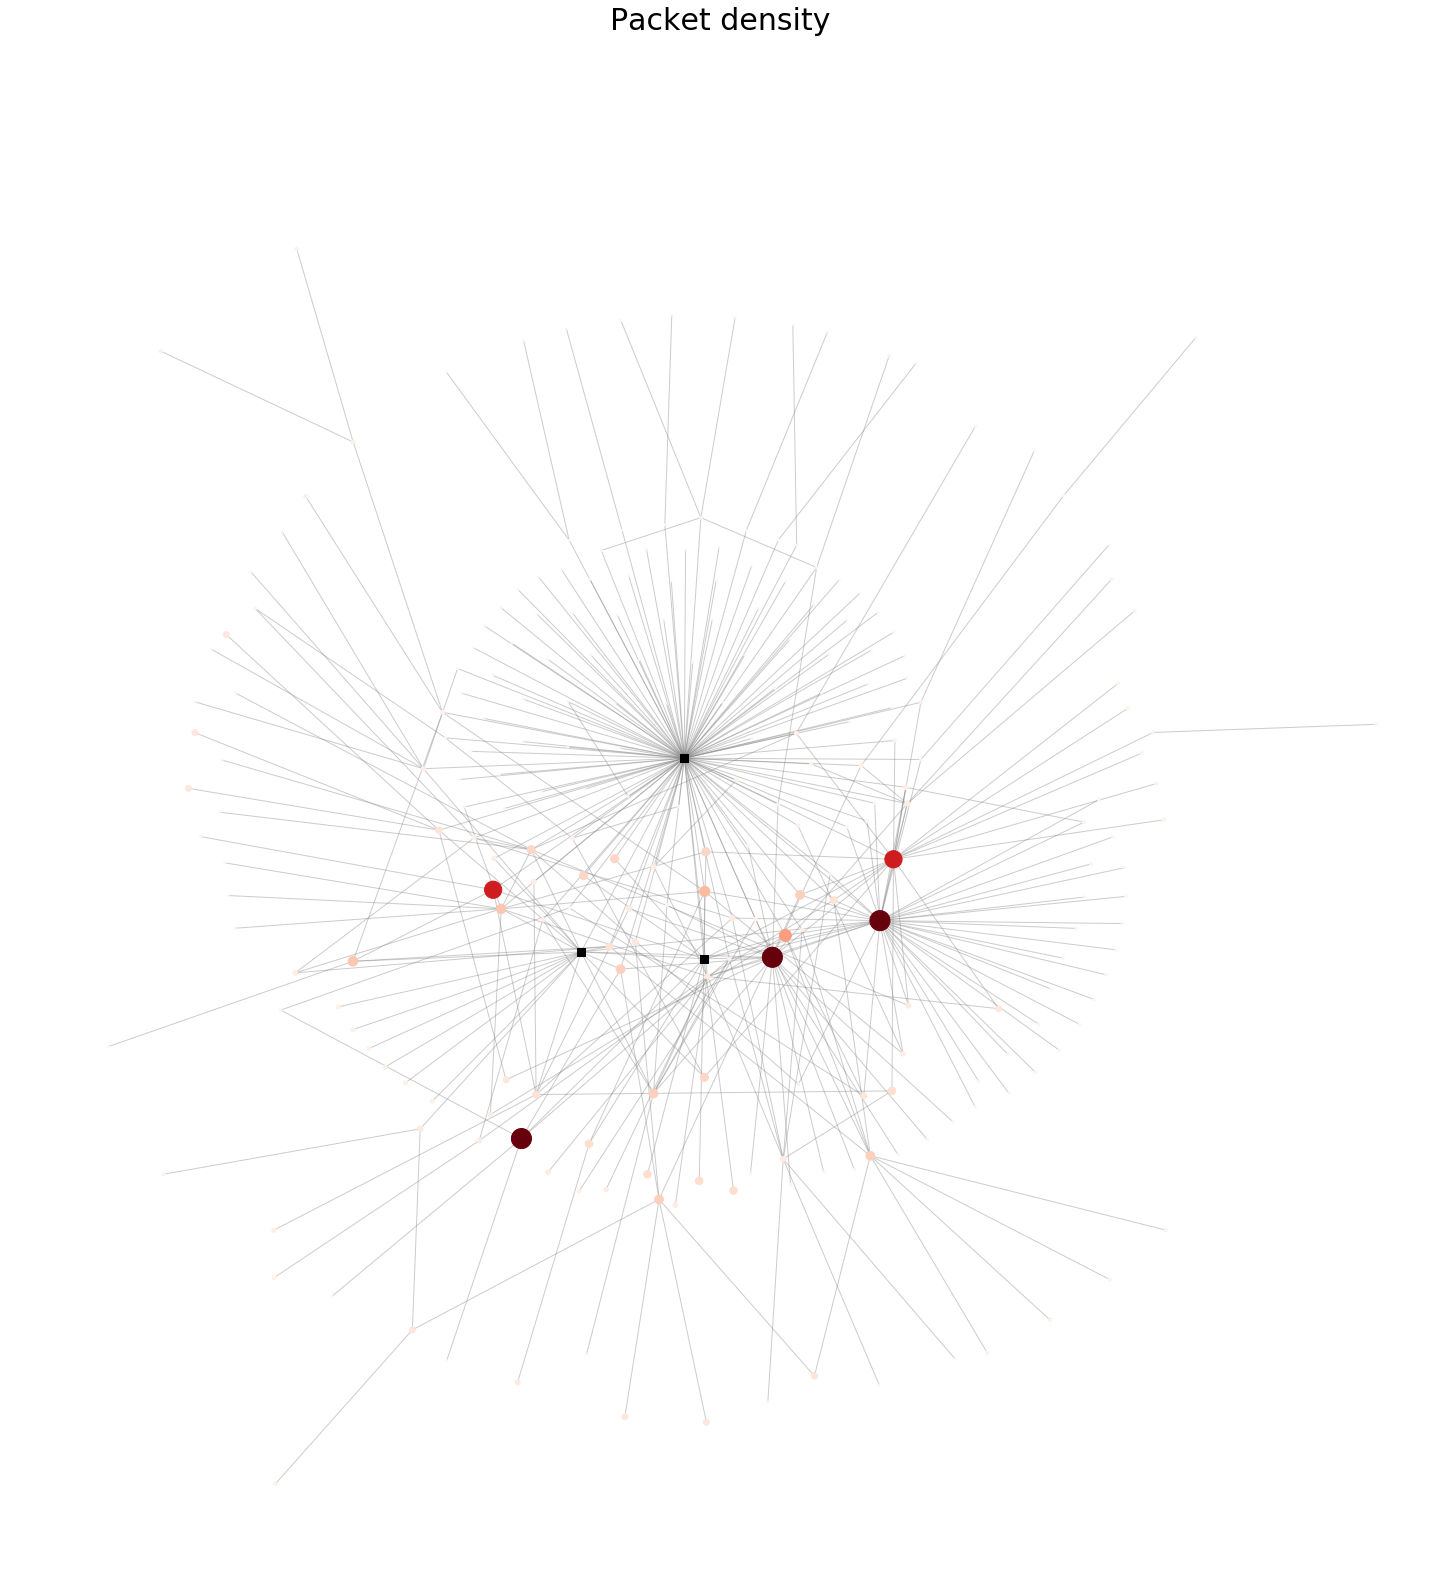

In [82]:
sim.graph('amount')

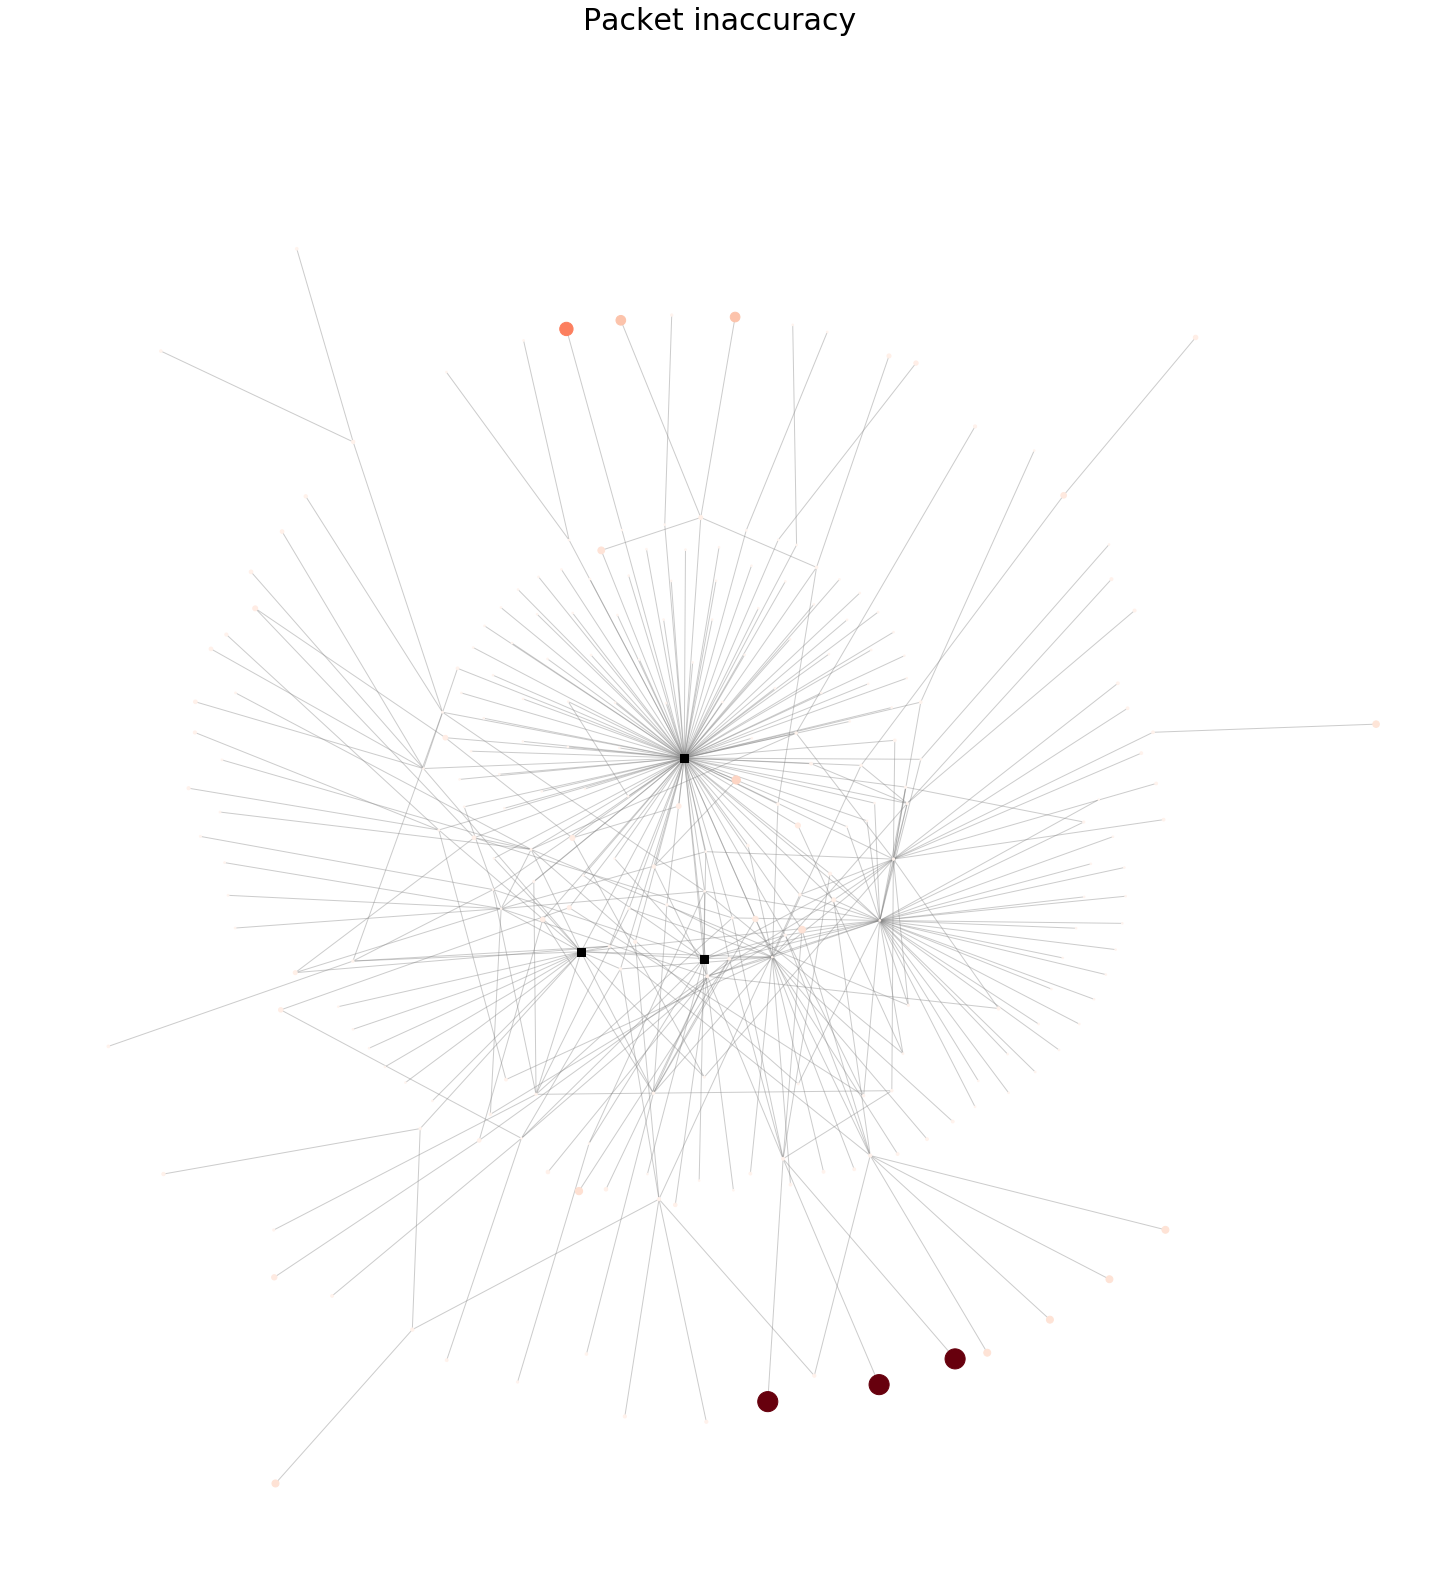

In [83]:
sim.graph('inacc')

Node<label: 3, amount: 11, recency: 502.3843101346808>
Node<label: 4, amount: 1, recency: 0.0>
Node<label: 5, amount: 33, recency: 0.0>
Node<label: 6, amount: 22, recency: 447.290480774402>
Node<label: 7, amount: 31, recency: 167.4550177652605>
Node<label: 8, amount: 23, recency: 185.73288401889064>
Node<label: 9, amount: 13, recency: 726.9773341657145>
Node<label: 10, amount: 33, recency: 0.0>
Node<label: 11, amount: 17, recency: 518.1571453478613>
Node<label: 12, amount: 16, recency: 642.1999096150914>
Node<label: 13, amount: 15, recency: 755.8199160023694>
Node<label: 14, amount: 18, recency: 252.52772664085063>
Node<label: 15, amount: 24, recency: 140.17538229759373>
Node<label: 16, amount: 22, recency: 906.3163470851329>
Node<label: 17, amount: 12, recency: 703.2094933636353>
Node<label: 18, amount: 12, recency: 270.5614418354768>
Node<label: 19, amount: 15, recency: 615.8029731640663>
Node<label: 20, amount: 6, recency: 398.4781939293809>
Node<label: 21, amount: 19, recency: 322.

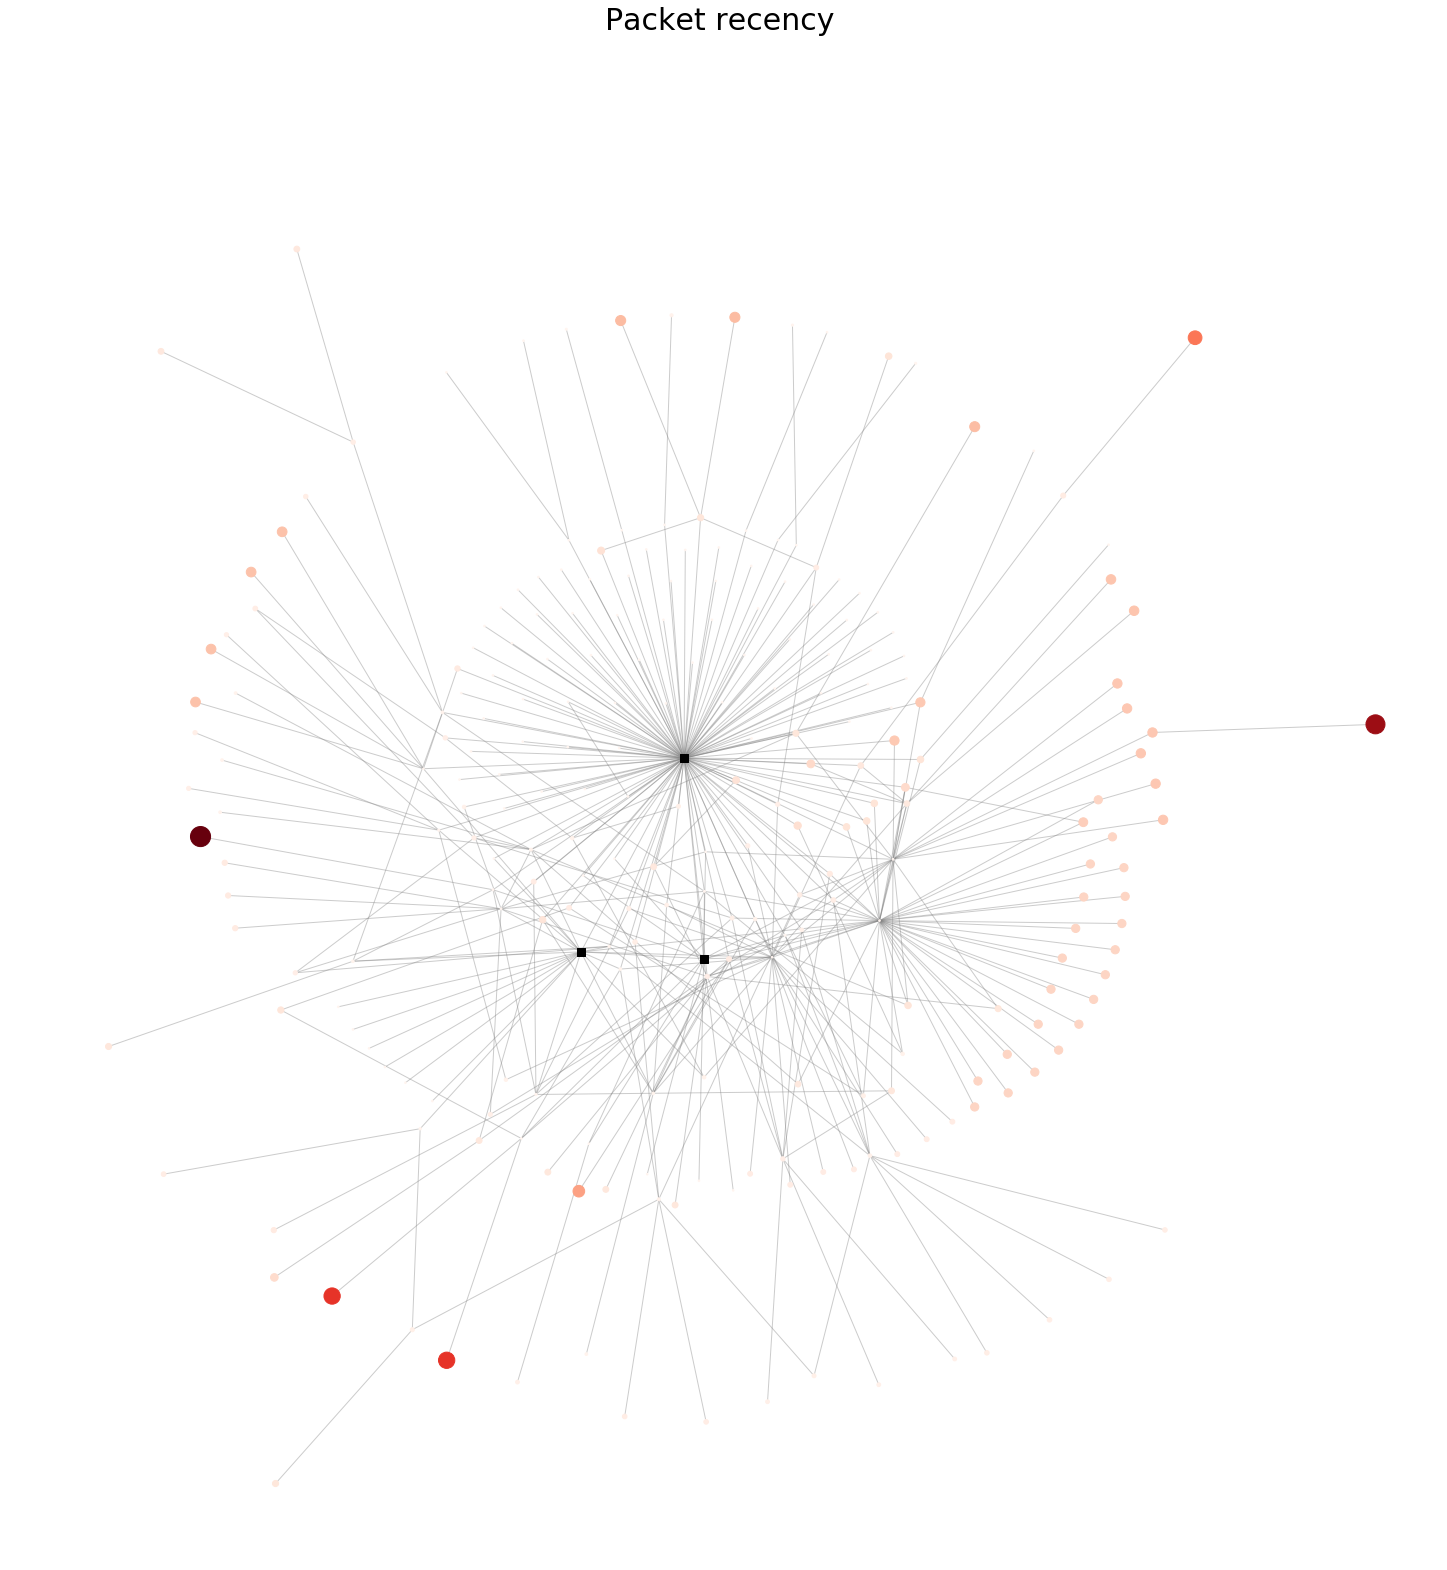

In [84]:
sim.graph('recency')